In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector


In [2]:

class MoneyAgent(Agent):
    """一个代理带有一些钱"""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

class MoneyModel(Model):
    """一个模型有一些代理"""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # 为模型创建代理
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

            # 将代理添加到随机的网格单元
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},  # 使用 'Gini' 函数计算模型的数据
            agent_reporters={"Wealth": "wealth"})  # 记录代理的 "wealth" 参数

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N-i) for i, xi in enumerate(x)) / (N*sum(x))
    return (1 + (1/N) - 2*B)

# 运行模型
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()


<Figure size 640x480 with 0 Axes>

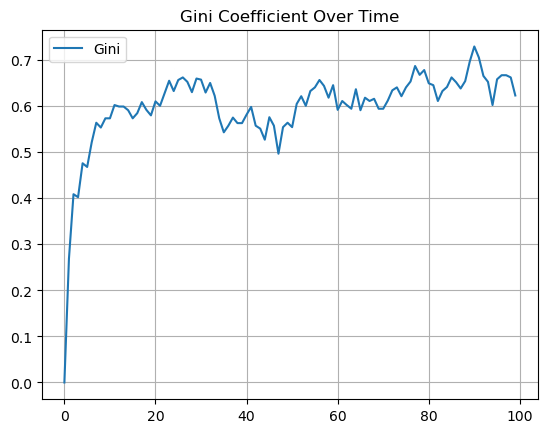

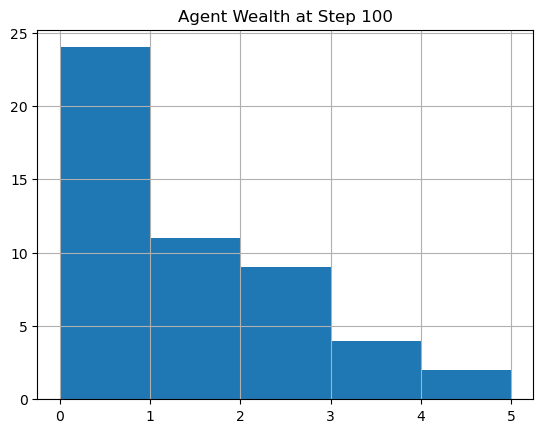

In [3]:
import matplotlib.pyplot as plt

# 运行模型
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()

# 获取模型层面的收集到的所有数据
model_data = model.datacollector.get_model_vars_dataframe()

# 获取代理层面的收集到的所有数据
agent_data = model.datacollector.get_agent_vars_dataframe()

# 绘制 Gini 系数的变化
plt.figure()
model_data.plot()
plt.title('Gini Coefficient Over Time')
plt.grid(True)
plt.show()

# 绘制最后一步中每个代理的财富分布
plt.figure()
agent_wealth = agent_data.xs(99, level="Step")["Wealth"]
agent_wealth.hist(bins=range(agent_wealth.max()+1))
plt.title('Agent Wealth at Step 100')
plt.grid(True)
plt.show()